# Logistic Regression and Decision Tree Performance

* Each model file has ~50k samples that are split into training and test sets
* We are using logistic regression and Decision Tree. Since we have class imbalanced, I am also experimenting with class_weight parameter
    * LR = Logistic Regression
    * LRB = Logistic Regression with class_weight == 'balanced'
    * DT = Decision Tree
    * DTB = Decision Tree with class_weight == 'balanced'
    
I did try KNN initially but predict time was quite slow and the results were not great so this became impractical.

Also, we are only initially using Decision Tree to represent our tree based models. If this performs well, we can try other ensemble or boosting methods

## Feature Engineering

| Name | Description |
|------|-------------|
| BoW | Bag of works. Variations using unigram and bigram |
| TFIDF | Term Frequency - Inverse Document Frequency. Variations using unigram and bigram. Max features is set to 10k so we only retain the most frequent 10k words |
| Word2Vec | Word 2 Vec embedding. This is an average embedding of all words in the review. There are 2 variations of this. If it's pretrained, it uses word2vec-google-news-300 else embeddings are trained with our corpus of reviews. Max features is set to 10k so we only retain the most frequent 10k words. Also, there are a couple different version of this using unigram (ngram11) and bigram (ngram22). Max features for this is set to 300 |
| Fasttext | Fasttext embedding. This is an average embedding of all words in the review. Embedding is trained with our corpus of review words. Also, there are a couple different version of this using unigram (ngram11) and bigram (ngram22). Max features for this is set to 300 |


# Summary of Results

* Logistic Regression is generally doing better than tree based model
    * with embedding lengths of 100, 300, 1000, Logistic regression is actually not able to converge at all even when experiementing with number of iterations (up to 300)
* Setting sample_weight to 'balanced' generally improved performance for all models with the most impact on Logistic Regression
* TF-IDF does slightly better than BoW's
* BoW and TF-IDF is generally doing better than embeddings - probably because there are more features available
* Using unigram actually out performed bigram slightly


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import importlib
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import util.model_util as mu
import util.report_util as ru

%matplotlib inline
sns.set()

CONFIG_DIR = "../config"
CONFIG_FILE = f'{CONFIG_DIR}/2019-11-01-run_classifiers-50k.csv'
REPORT_DIR = "../reports"
REPORT_FILE = f'{REPORT_DIR}/2019-11-01-run_classifiers-50k-report copy.csv'

/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Running our Models

Jupyter notebook was not stable for me when running models for some reason. So I created a program that takes in configuration files and runs all models serially.

To run this again, execute the following command in the tools directory:

```
python run_classifiers.py ../config/2019-11-01-run_classifiers-50k.csv 2>&1 | tee run_classifiers.log
```

# Our Configuration File

In [2]:
pd.set_option('max_colwidth', 150)
config = pd.read_csv(CONFIG_FILE)
config

,data_dir,data_file,class_column,dtype,drop_columns,model_name,max_iter,sampling,status,status_date,message
0,../dataset/feature_files,review_body-word2vec-df_none-ngram_none-47523-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",LR,100.0,NaN,NaN,NaN,NaN
1,../dataset/feature_files,review_body-word2vec-df_none-ngram_none-47523-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",LRB,100.0,NaN,NaN,NaN,NaN
2,../dataset/feature_files,review_body-word2vec-df_none-ngram_none-47523-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",DT,NaN,NaN,NaN,NaN,NaN
3,../dataset/feature_files,review_body-word2vec-df_none-ngram_none-47523-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",DTB,NaN,NaN,NaN,NaN,NaN
4,../dataset/feature_files,review_body-word2vec-df_none-ngram_none-47523-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",LR,100.0,NaN,NaN,NaN,NaN
5,../dataset/feature_files,review_body-word2vec-df_none-ngram_none-47523-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",LRB,100.0,NaN,NaN,NaN,NaN
6,../dataset/feature_files,review_body-word2vec-df_none-ngram_none-47523-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",DT,NaN,NaN,NaN,NaN,NaN
7,../dataset/feature_files,review_body-word2vec-df_none-ngram_none-47523-10000-nolda.csv,star_rating,NaN,"helpful_votes, total_votes, helpful_product",DTB,NaN,NaN,NaN,NaN,NaN


# Metrics Evaluation

I want to have one metric that we can use to evaluate our models easier instead of looking at precision and recall for all classes. We saw that there is high class imbalance from our dataset, with most reviews coming in with 5-star ratings.

I want to make sure that we do a better job identifying un-represented classes (ie, 2, 3, 4 star ratings). Instead of using general model accuracy which places equal weights on all classes. I will calculate a metric using the harmonic mean of recall for under represented class (star rating 2, 3, 4) and precision for majority classes (star rating 1 and 5)

Code for this is listed below:

In [3]:
??ru._harmonic_mean

Signature: ru._harmonic_mean(data: pandas.core.frame.DataFrame, column_name) -> pandas.core.frame.DataFrame
Source:   
def _harmonic_mean(data:pd.DataFrame, column_name) -> pd.DataFrame:
    """
    Calcuates one metric score using harmonic mean using precision for star 1 and 5, recall for stars 2, 3, 4

    :param data:
    :param column_name:
    :return:
    """
    data[column_name] = 5 / (1/data[EVAL_COLS[0]] +
                                 1/data[EVAL_COLS[1]] +
                                 1/data[EVAL_COLS[2]] +
                                 1/data[EVAL_COLS[3]] +
                                 1/data[EVAL_COLS[4]])
    return data
File:      ~/Dropbox/0_springboard/capstone/util/report_util.py
Type:      function


# Results

In [4]:
report = ru.load_report(REPORT_FILE)

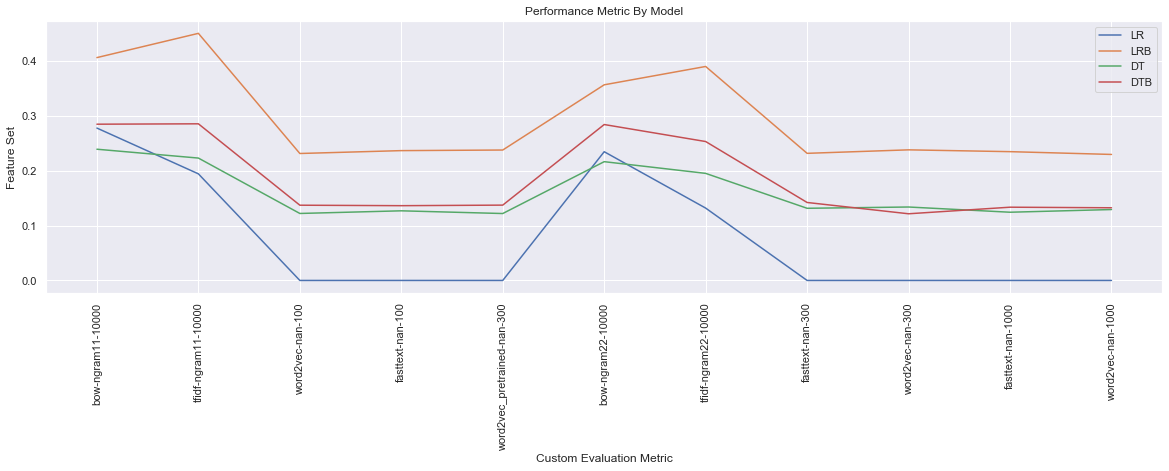

In [5]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

for model in report.model_name.unique():
    current = report[report.model_name == model]
    sns.lineplot(data=current, x="feature_summary", y="eval_metric", label=model, sort=False)
    
_ = plt.title("Performance Metric By Model")
_ = plt.xticks(rotation=90)
_ = plt.xlabel("Custom Evaluation Metric")
_ = plt.ylabel("Feature Set")

# Recall for Minority Classes

The shape of the lines look roughly the same with values being slightly lower, meaning that the eval_metric we used is generally doing a pretty good job representing recall for minority classes.

LRB still does the best here

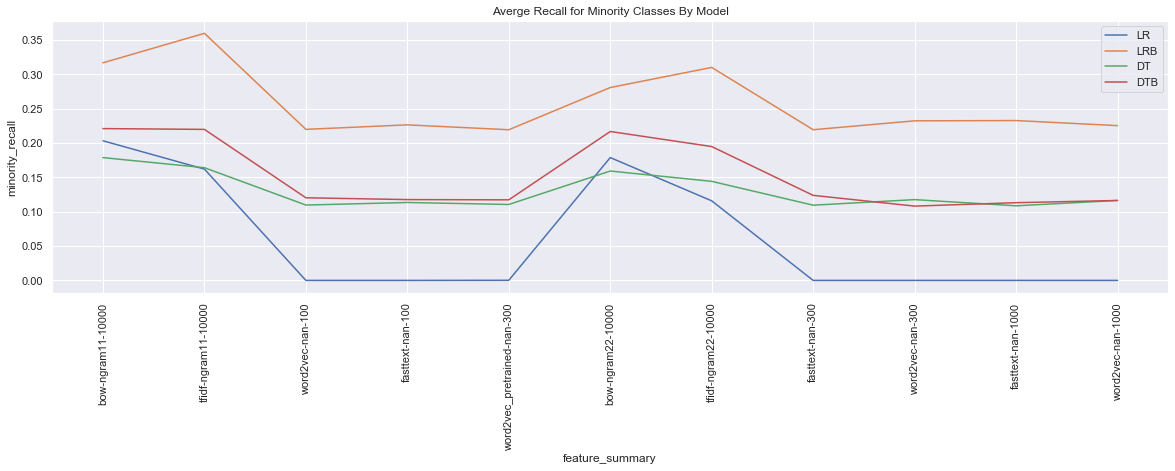

In [6]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

report["minority_recall"] = (report["2_recall"] + report["3_recall"] + report["4_recall"]) /3

for model in report.model_name.unique():
    current = report[report.model_name == model]
    sns.lineplot(data=current, x="feature_summary", y="minority_recall", label=model, sort=False)
    
_ = plt.title("Averge Recall for Minority Classes By Model")
_ = plt.xticks(rotation=90)

# On average, tree based models are doing better than Logistic Regression. However, when class_weight is specific to be 'balanced', LR out performs tree based model.

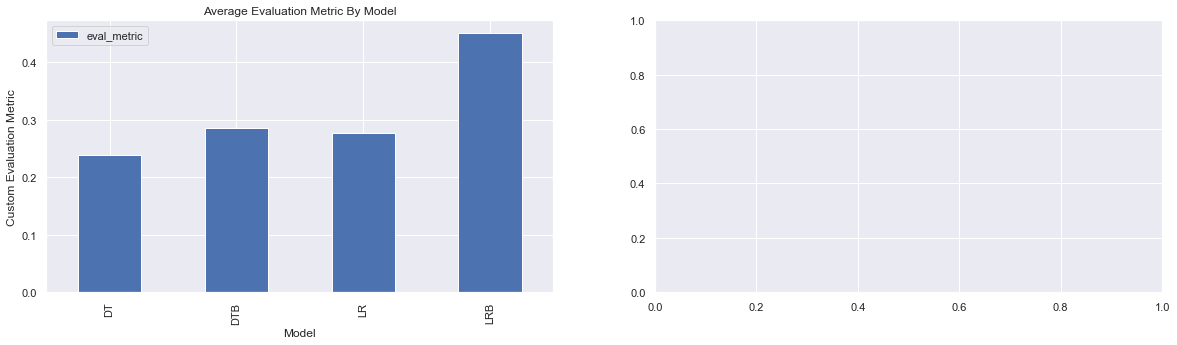

In [12]:
f, a = plt.subplots(1, 2, figsize=(20, 5))

report[["model_name", "eval_metric"]].groupby("model_name").max().plot(kind='bar', ax=a[0])
_ = a[0].set_title("Average Evaluation Metric By Model")
_ = a[0].set_xlabel("Model")
_ = a[0].set_ylabel("Custom Evaluation Metric")



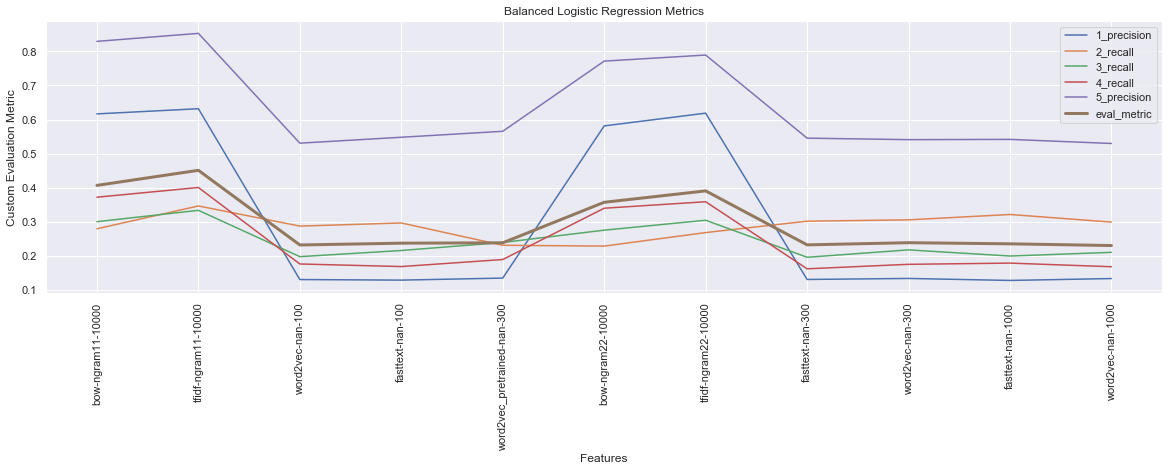

In [9]:
# for model in report.model_name.unique():

f, a = plt.subplots(1, 1, figsize=(20, 5))
current = report[report.model_name == 'LRB']
sns.lineplot(data=current, x="feature_summary", y="1_precision", label="1_precision", sort=False)
sns.lineplot(data=current, x="feature_summary", y="2_recall", label="2_recall", sort=False)
sns.lineplot(data=current, x="feature_summary", y="3_recall", label="3_recall", sort=False)
sns.lineplot(data=current, x="feature_summary", y="4_recall", label="4_recall", sort=False)
sns.lineplot(data=current, x="feature_summary", y="5_precision", label="5_precision", sort=False)
sns.lineplot(data=current, x="feature_summary", y="eval_metric", label="eval_metric", sort=False, linewidth='3')
_ = plt.title("Balanced Logistic Regression Metrics")
_ = plt.xticks(rotation=90)
_ = plt.xlabel("Features")
_ = plt.ylabel("Custom Evaluation Metric")